In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import os
import mne
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
import tensorflow
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Dense, Activation, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dropout, BatchNormalization, Input,UpSampling1D
from tensorflow.keras.layers import concatenate, Lambda, Conv2D, MaxPooling2D, GlobalAveragePooling2D,LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch

c:\Users\ryoii\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\ryoii\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# path config
parent_dir = os.path.dirname(os.getcwd())
os.chdir(parent_dir)
print("Updated Working Directory: ", os.getcwd())

Updated Working Directory:  c:\Users\ryoii\Desktop\EEG2IMAGE


In [3]:
from __00_load_csv import load_alphabet, load_digit, load_object
from __01_transform_data import transform_eeg_data, process_band, MA_X, MA_X2
from __02_model import train, visualize
from __03_utils import plot_eeg, downsample, plot_eeg_1280

In [4]:
def apply_bandpass_filter(data, sampling_rate, low_cutoff, high_cutoff):
    """
    Apply a bandpass filter to 3D EEG data.
    
    Parameters:
        data (numpy.ndarray): Input EEG data of shape (n_samples, n_channels, n_points).
        sampling_rate (float): Sampling frequency of the data (in Hz).
        low_cutoff (float): Low cutoff frequency for the bandpass filter (in Hz).
        high_cutoff (float): High cutoff frequency for the bandpass filter (in Hz).

    Returns:
        numpy.ndarray: Filtered EEG data of the same shape as the input.
    """
    # Design a Butterworth bandpass filter
    nyquist = 0.5 * sampling_rate
    normalized_low = low_cutoff / nyquist
    normalized_high = high_cutoff / nyquist
    b, a = butter(N=4, Wn=[normalized_low, normalized_high], btype='band', analog=False)

    # Apply the filter to each channel
    filtered_data = np.zeros_like(data)
    for sample_idx in range(data.shape[0]):
        for channel_idx in range(data.shape[1]):
            filtered_data[sample_idx, channel_idx, :] = filtfilt(b, a, data[sample_idx, channel_idx, :])

    return filtered_data

In [5]:
def plot_eeg_signal(X, channel_index, sample_limit=200):
    """
    Plot the EEG signal for a specific channel.

    Parameters:
    X (numpy.ndarray): The feature matrix of shape (230, 14, 1280).
    channel_index (int): The index of the channel to visualize (0-13).
    sample_limit (int): The number of samples to plot on the x-axis (default is 200).
    """
    if channel_index < 0 or channel_index >= X.shape[1]:
        raise ValueError("Invalid channel index. Must be between 0 and 13.")

    # Select the first instance for visualization
    signal = X[0, channel_index, :sample_limit]

    # Plot the signal
    plt.figure(figsize=(10, 5))
    plt.plot(signal)
    plt.title(f"EEG Signal - Channel {channel_index}")
    plt.xlabel("Sample Number")
    plt.ylabel("Amplitude (\u03bcV)")
    plt.grid(True)
    plt.show()

In [6]:
# preprocess - with edge padding
def preprocess_eeg_data(X):
    """
    Preprocess the EEG data using a moving average filter.

    Parameters:
        X (numpy.ndarray): Raw EEG data of shape (n_samples, n_channels, n_points).

    Returns:
        numpy.ndarray: Preprocessed EEG data of the same shape.
    """
    def moving_average(signal, window_size=5):
        # Pad edges to ensure proper filtering at the boundaries
        padded_signal = np.pad(signal, pad_width=window_size//2, mode='edge')
        smoothed_signal = np.convolve(padded_signal, np.ones(window_size) / window_size, mode='valid')
        return smoothed_signal

    X_preprocessed = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X_preprocessed[i, j, :] = moving_average(X[i, j, :])
    return X_preprocessed

In [7]:
def segment_eeg_data(X, Y, sampling_rate=128, segment_duration=0.05, overlap=0):
    """
    Segment EEG data with a specified overlap percentage for fine-level classification.

    Parameters:
        X (numpy.ndarray): EEG data of shape (n_samples, n_channels, n_points).
        Y (numpy.ndarray): Labels of shape (n_samples,).
        sampling_rate (int): Sampling rate of the EEG data (Hz).
        segment_duration (float): Duration of each segment in seconds.
        overlap (float): Overlap between segments as a fraction (0 to 1).

    Returns:
        tuple: Segmented EEG data and expanded labels.
    """
    segment_size = int(sampling_rate * segment_duration)  # Calculate segment size
    step_size = int(segment_size * (1 - overlap))  # Calculate step size based on overlap
    n_samples, n_channels, n_points = X.shape

    if step_size <= 0:
        raise ValueError("Overlap too large, step size must be greater than 0.")
    
    # Calculate the number of segments per sample with the given overlap
    n_segments = max(1, (n_points - segment_size) // step_size + 1)
    
    # Initialize arrays for segmented data
    X_segmented = np.zeros((n_samples * n_segments, n_channels, segment_size))
    Y_expanded = np.repeat(Y, n_segments)

    for i in range(n_samples):
        for j in range(n_segments):
            start = j * step_size
            end = start + segment_size
            if end <= n_points:
                X_segmented[i * n_segments + j, :, :] = X[i, :, start:end]

    return X_segmented, Y_expanded


In [8]:
def extract_features(X_segmented):
    """
    Extract features (SD, RMS, SUM, E) from segmented EEG data.

    Parameters:
        X_segmented (numpy.ndarray): Segmented EEG data.

    Returns:
        numpy.ndarray: Feature matrix of shape (n_segments, n_channels * 4).
    """
    n_segments, n_channels, segment_size = X_segmented.shape
    feature_matrix = np.zeros((n_segments, n_channels * 5))
    for i in range(n_segments):
        for j in range(n_channels):
            segment = X_segmented[i, j, :]
            psd, _ = welch(segment, fs=128, nperseg=segment_size)

            feature_matrix[i, j * 4] = np.std(segment)  # Standard Deviation (SD)
            feature_matrix[i, j * 4 + 1] = np.sqrt(np.mean(segment ** 2))  # Root Mean Square (RMS)
            feature_matrix[i, j * 4 + 2] = np.sum(segment)  # Sum (SUM)
            feature_matrix[i, j * 4 + 3] = np.sum(segment ** 2)  # Energy (E)
            feature_matrix[i, j * 5 + 4] = np.mean(psd)  # Average PSD
    return feature_matrix


In [9]:
def train_evaluate_classifier(X, Y, fine_level_class=None):
    """
    Train and evaluate a Random Forest classifier using stratified 10-fold cross-validation
    for fine-level classification based on class type (digits, characters, or objects).
    Also visualizes feature importance.

    Parameters:
        X (numpy.ndarray): Feature matrix.
        Y (numpy.ndarray): Labels array.
        fine_level_class (str): Type of fine classification ("digits", "characters", or "objects").

    Returns:
        None
    """
    # Set number of trees based on fine-level class
    if fine_level_class == "digits":
        n_trees = 40
    elif fine_level_class == "characters":
        n_trees = 23
    elif fine_level_class == "objects":
        n_trees = 36
    else:
        raise ValueError("Invalid fine_level_class. Choose from 'digits', 'characters', or 'objects'.")

    # Initialize the classifier with class weights
    rf_clf = RandomForestClassifier(
        n_estimators=n_trees,
        criterion='gini',
        random_state=42,
        class_weight='balanced'  # Automatically handles class imbalance
    )

    # Perform stratified 10-fold cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    all_y_true = []
    all_y_pred = []

    for train_index, test_index in skf.split(X, Y):
        # Split data into training and test sets for this fold
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Train the classifier
        rf_clf.fit(X_train, Y_train)

        # Predict on the test set
        Y_pred = rf_clf.predict(X_test)

        # Store predictions and true labels
        all_y_true.extend(Y_test)
        all_y_pred.extend(Y_pred)

    # Evaluate overall performance
    print(f"Cross-Validation Accuracy ({fine_level_class}):", accuracy_score(all_y_true, all_y_pred))
    print(f"Classification Report ({fine_level_class}):\n", classification_report(all_y_true, all_y_pred))

    # Feature Importance
    feature_importances = rf_clf.feature_importances_

    # Dynamically create feature names
    feature_types = [
                "sd", "rms", "sum_", "energy", "kurt", "skewness", "activity", "mobility", 
                "complexity"
            ]  # Update with all feature types you use
    n_features_per_channel = len(feature_types)
    n_channels = X.shape[1] // n_features_per_channel

    # Calculate average importance for each feature type
    avg_importance_by_type = {ft: 0 for ft in feature_types}
    for i, ft in enumerate(feature_types):
        avg_importance_by_type[ft] = np.mean(feature_importances[i::n_features_per_channel])

    # Plot average importance by feature type
    plt.figure(figsize=(8, 4))
    plt.bar(avg_importance_by_type.keys(), avg_importance_by_type.values())
    plt.xlabel("Feature Type")
    plt.ylabel("Average Importance")
    plt.title("Average Feature Importance by Type")
    plt.tight_layout()
    plt.show()

    # Print the values for reference
    for ft, importance in avg_importance_by_type.items():
        print(f"Average Importance for {ft}: {importance:.4f}")




In [10]:
# # load raw data
# fo = os.path.join(parent_dir, 'data', 'Vie2Image', 'Char')

# X, Y = load_alphabet(fo) # (220, 2, 6000)
# X = downsample(X)
# X_filtered = apply_bandpass_filter(X, sampling_rate=600, low_cutoff=1, high_cutoff=64)
# plot_eeg_signal(X_filtered, sample_limit=200, channel_index=0)
# X_preprocessed = preprocess_eeg_data(X_filtered) # (220, 2, 1280)
# plot_eeg_signal(X_preprocessed, sample_limit=200, channel_index=0)
# X_segmented, Y_expanded = segment_eeg_data(X_preprocessed, Y, sampling_rate=128, segment_duration=0.05, overlap=0) #(46860, 2, 6) (220000,)
# plot_eeg_signal(X_segmented, sample_limit=200, channel_index=0)
# X_features = extract_features(X_segmented) # (46860, 10)
# train_evaluate_classifier(X_features, Y_expanded, fine_level_class='characters')

Downsampling EEG Data: 100%|██████████| 220/220 [00:00<00:00, 4822.88it/s]


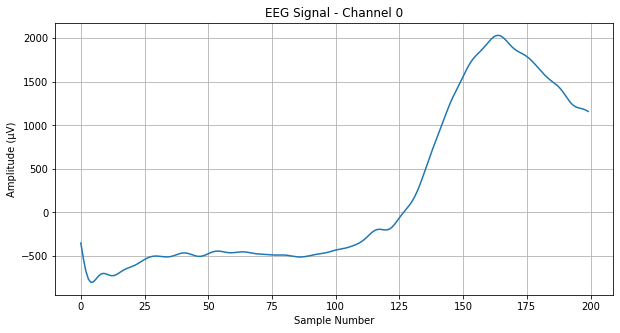

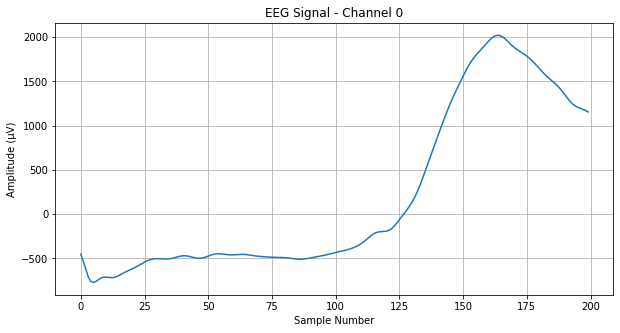

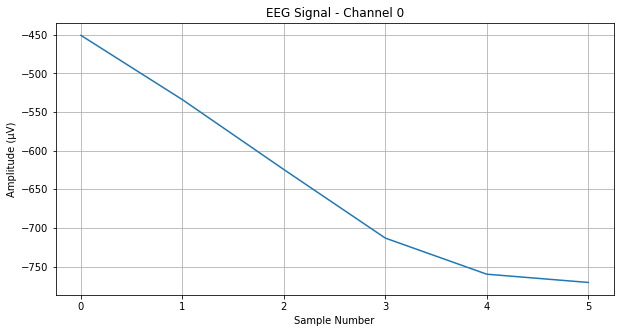

In [11]:
# load raw data
fo = os.path.join(parent_dir, 'data', 'Vie2Image', 'Digit')

X, Y = load_digit(fo) # (220, 2, 6000)
X = downsample(X)
X_filtered = apply_bandpass_filter(X, sampling_rate=600, low_cutoff=1, high_cutoff=64)
plot_eeg_signal(X_filtered, sample_limit=200, channel_index=0)
X_preprocessed = preprocess_eeg_data(X_filtered) # (220, 2, 6000)
plot_eeg_signal(X_preprocessed, sample_limit=200, channel_index=0)
X_segmented, Y_expanded = segment_eeg_data(X_preprocessed, Y, sampling_rate=128, segment_duration=0.05, overlap=0.5) #(220000, 2, 6) (220000,)
plot_eeg_signal(X_segmented, sample_limit=200, channel_index=0)
X_features = extract_features(X_segmented) # (46860, 10)
# train_evaluate_classifier(X_features, Y_expanded, fine_level_class='digits')

In [12]:
# # load raw data
# fo = os.path.join(parent_dir, 'data', 'Vie2Image', 'Image')

# X, Y = load_object(fo) # (220, 2, 6000)
# X = downsample(X)
# X_filtered = apply_bandpass_filter(X, sampling_rate=600, low_cutoff=1, high_cutoff=64)
# plot_eeg_signal(X_filtered, sample_limit=200, channel_index=0)
# X_preprocessed = preprocess_eeg_data(X_filtered) # (220, 2, 6000)
# plot_eeg_signal(X_preprocessed, sample_limit=200, channel_index=0)
# X_segmented, Y_expanded = segment_eeg_data(X_preprocessed, Y, sampling_rate=128, segment_duration=0.05, overlap=0.5) #(220000, 2, 6) (220000,)
# plot_eeg_signal(X_segmented, sample_limit=200, channel_index=0)
# X_features = extract_features(X_segmented) # (46860, 10)
# train_evaluate_classifier(X_features, Y_expanded, fine_level_class='objects')

In [13]:
import pickle
with open("X_features_emotiv_digit.pkl", 'rb') as f:
    data = pickle.load(f)
X_emotiv, y_emotiv = data['x_processed'], data['y_raw']
print(X_emotiv.shape)

(230, 14, 1280)


In [19]:
import numpy as np

# Assume Vie dataset shape: (220, 2, 1280)
# Assume Emotiv dataset shape: (230, 14, 1280)

def upsample_vie_channels(vie_data, target_channels):
    """
    Upsample Vie dataset to match the target number of channels.
    :param vie_data: Original Vie dataset (instances, channels, data points).
    :param target_channels: Number of channels to upsample to.
    :return: Upsampled Vie dataset.
    """
    instances, original_channels, data_points = vie_data.shape
    upsampled_data = np.zeros((instances, target_channels, data_points))

    # Duplicate existing channels to match target channels
    for i in range(target_channels):
        upsampled_data[:, i, :] = vie_data[:, i % original_channels, :]
    
    return upsampled_data

# Upsample Vie dataset to 14 channels
X_vie_upsampled = upsample_vie_channels(X_filtered, target_channels=14)
print("Original Vie shape:", X_filtered.shape)
print("Upsampled Vie shape:", X_vie_upsampled.shape)
X_preprocessed = preprocess_eeg_data(X_vie_upsampled)

print(X_preprocessed.shape)
print(X_emotiv.shape)


Original Vie shape: (220, 2, 1280)
Upsampled Vie shape: (220, 14, 1280)
(220, 14, 1280)
(230, 14, 1280)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.models import load_model

# Model architecture
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Input shape and classes
input_shape = (14, 1280)  # Channels, Data Points
num_classes = 10          # Example number of classes

# Step 1: Train on Emotiv Dataset
model = create_model(input_shape, num_classes)
model.fit(X_emotiv, y_emotiv, epochs=20, batch_size=32, validation_split=0.2)
model.save("pretrained_emotiv_model.h5")

# Step 2: Fine-Tune on Vie Dataset
pretrained_model = load_model("pretrained_emotiv_model.h5")

# Optionally freeze some layers
for layer in pretrained_model.layers[:-2]:  # Freeze all but the last 2 layers
    layer.trainable = False

# Recompile the model
pretrained_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fine-tune on Vie dataset
pretrained_model.fit(X_preprocessed, Y, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate on Vie dataset
accuracy = pretrained_model.evaluate(X_preprocessed, Y)[1]
print(f"Fine-Tuned Accuracy on Vie Dataset: {accuracy * 100:.2f}%")


Epoch 1/20


c:\Users\ryoii\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.0542 - loss: 2.5083 - val_accuracy: 0.1087 - val_loss: 2.3638
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1015 - loss: 2.5299 - val_accuracy: 0.0870 - val_loss: 2.3695
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0584 - loss: 2.4542 - val_accuracy: 0.0870 - val_loss: 2.3535
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1015 - loss: 2.3879 - val_accuracy: 0.1087 - val_loss: 2.3298
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0792 - loss: 2.3961 - val_accuracy: 0.1087 - val_loss: 2.3072
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0619 - loss: 2.4177 - val_accuracy: 0.1087 - val_loss: 2.3096
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1023 - loss: 2.4064 - val_accuracy: 0.1087 - val_loss: 2.3088
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1332 - loss: 2.3329 - val_accuracy: 0.1087 - val_loss: 2.3106
Epoch 9/20


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.1060 - loss: 2.3981 - val_accuracy: 0.0682 - val_loss: 2.5270
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1401 - loss: 2.4342 - val_accuracy: 0.0455 - val_loss: 2.5263
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0983 - loss: 2.4156 - val_accuracy: 0.0455 - val_loss: 2.5261
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1236 - loss: 2.3634 - val_accuracy: 0.0455 - val_loss: 2.5251
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0927 - loss: 2.4022 - val_accuracy: 0.0227 - val_loss: 2.5237
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1064 - loss: 2.4537 - val_accuracy: 0.0227 - val_loss: 2.5231
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0974 - loss: 2.3893 - val_accuracy: 0.0227 - val_loss: 2.5229
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1009 - loss: 2.3983 - val_accuracy: 0.0227 - val_loss: 2.5222


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 220
'y' sizes: 93500
